In [101]:
import numpy as np 
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix

## ROC

In [48]:
def view_ROC_AUC(train_Y, train_Y_proba, model_name):
    y_one_hot = pd.get_dummies(y).values
    train_fpr, train_tpr , thresholds = roc_curve(y_one_hot.ravel(),train_Y_proba.ravel())
    train_auc = auc(train_fpr, train_tpr)
    plt.plot(train_fpr, train_tpr, color = 'r', linewidth = 2, alpha = 0.7, label = u'AUC=%.3f' % train_auc)
    plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
    plt.xlim((-0.01, 1.02))
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.grid( b = True, ls=':')
    plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
    plt.title(u"train data's ROC&AUC ", fontsize=17)
    
    plt.savefig( "{}_ROC_curve&AUC.png".format(model_name))
    plt.show()

## KNN

In [38]:
class KNN():
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
    def fit(self,train_X, train_y):
        self.train_X = train_X
        self.train_y = train_y
        self.labels_set = sorted(list(set(train_y)))
        self.n_classes = len(self.labels_set)
        
    def predict_proba(self, X):
        n_samples = len(X)
        y_proba = np.zeros( (n_samples, self.n_classes) )
        for i,item in enumerate(X.values):
            diss = item - self.train_X
            diss_square = diss**2
            total_diss_square = diss_square.sum(axis = 1)
            ind = total_diss_square.sort_values().index[: self.n_neighbors]
            labels = self.train_y[ind]
            for j, label in enumerate(self.labels_set):
                y_proba[i,j] =  (labels==label).sum() / self.n_neighbors

        return y_proba
    
    def predict(self,X):
        y_proba = self.predict_proba( X)
        n_samples = len(X)
        y_pred = np.zeros( n_samples , dtype = int )
        for i, proba in enumerate(y_proba):
            ind = np.where(proba  == max(proba) )[0][0]
            y_pred[i] = self.labels_set[ind]
        return y_pred
    


In [39]:
df = pd.read_excel('dataset.php.xlsx', header = 1)
X = df.drop('Class', axis = 1)
y = df['Class']
            
knn = KNN(n_neighbors=10)
knn.fit(X,y)
y_proba = knn.predict_proba(X)
Y_pred = knn.predict(X)
acc_score = accuracy_score(y ,Y_pred)
acc_score

0.8946528332003192

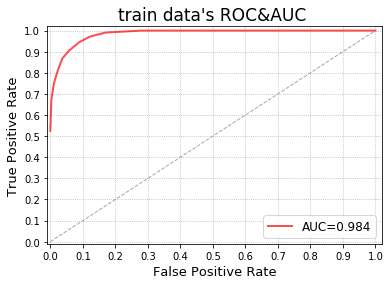

In [49]:
view_ROC_AUC(y, y_proba, model_name = 'KNN')

## Perceptron

In [50]:
df = pd.read_excel('dataset.php.xlsx', header = 1)
X = df.drop('Class', axis = 1)
y = df['Class']

labels = (np.arange(-1,2) == y[:,None]).astype(np.float32) 
NN_inputs = X.values.astype(np.float32)

def get_batch(x, y, batch_size):
    m, n = x.shape
    num_batch = m // batch_size + 1
    for i in range(num_batch):
        x_batch = x[i*batch_size: (i+1)*batch_size, :]
        y_batch = y[i*batch_size:( i+1)*batch_size, :]
        yield x_batch, y_batch
        
# Parameter
learning_rate = 0.01
time_steps = 100
batch_size = 64
n_hiddle = 88

n_inputs = NN_inputs.shape[1]
n_classes = labels.shape[1]
        

### establish NetWork

In [51]:
# placeholder
x = tf.placeholder(tf.float32, [None, n_inputs] , name = 'input')
y = tf.placeholder(tf.float32, [None, n_classes], name = 'labels' )

# Weight
W1 = tf.Variable(tf.random_normal(shape =[n_inputs, n_hiddle], mean = 0.0,stddev=0.1), dtype=tf.float32, name = 'W1')
b1 = tf.Variable(tf.zeros(n_hiddle), dtype = tf.float32 , name = 'b1')

# hiddle layer
input_1 = tf.add(tf.matmul(x,W1), b1)
output_1 = tf.nn.relu(input_1)

# Weight
W2 = tf.Variable(tf.random_normal(shape=[n_hiddle,n_classes],mean=0.0,stddev=0.1), dtype=tf.float32, name = 'W2')
b2 = tf.Variable(tf.zeros(n_classes), dtype = tf.float32 , name = 'b2')

logits = tf.add(tf.matmul(output_1,W2), b2)

loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(labels = y , logits = logits))
optimizier = tf.train.AdamOptimizer(learning_rate).minimize(loss)

prediction = tf.nn.softmax(logits)

### train Network

In [52]:
loss_record = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(time_steps):
        total_loss = 0
        y_probas = np.zeros( [1,n_classes] )
        for x_batch , y_batch in get_batch(NN_inputs , labels, batch_size):
            _, curr_loss, y_pred = sess.run([optimizier, loss, prediction], feed_dict={x:x_batch, y:y_batch})
            total_loss += curr_loss
            y_probas = np.concatenate([y_probas,y_pred])
        loss_record.append(total_loss)
        
        if epoch % 20 == 0:
            print("epoch: %i , loss: %.3f"%(epoch, total_loss))
            
y_probas = y_probas[1:]

y_preds = []
for proba in y_probas:
    L = list(proba)
    label = L.index(proba.max()) - 1
    y_preds.append(label)
    
accuracy_score(df['Class'], y_preds)

epoch: 0 , loss: 12.053
epoch: 20 , loss: 4.037
epoch: 40 , loss: 3.007
epoch: 60 , loss: 2.541
epoch: 80 , loss: 2.292


0.9449321628092577

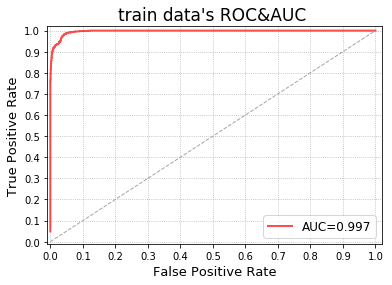

In [66]:
df = pd.read_excel('dataset.php.xlsx', header = 1)
X = df.drop('Class', axis = 1)
y = df['Class']

view_ROC_AUC(y, y_probas, model_name = 'Perceptron')

##  Naïve Bayes

In [88]:
class NaiveBayesBase():
    def __init__(self):
        pass

    def fit(self, trainMatrix, trainCategory):
        numTrainDocs = len(trainMatrix)
        numWords = len(trainMatrix[0])
        self.pAbusive = sum(trainCategory) / float(numTrainDocs)
        p0Num = np.ones(numWords)
        p1Num = np.ones(numWords)
        p0Denom = 1
        p1Denom = 1
        for i in range(numTrainDocs):
            if trainCategory[i] == 1:
                p1Num += trainMatrix[i]
                p1Denom += sum(trainMatrix[i])
            else:
                p0Num += trainMatrix[i]
                p0Denom += sum(trainMatrix[i])
        self.p1Vect = np.log(p1Num / p1Denom)
        self.p0Vect = np.log(p0Num / p0Denom)
        return self

    def predict(self, testX):
        p1 = np.sum(testX * self.p1Vect) + np.log(self.pAbusive)
        p0 = np.sum(testX * self.p0Vect) + np.log(1 - self.pAbusive)
        if p1 > p0:
            return 1
        else:
            return 0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log


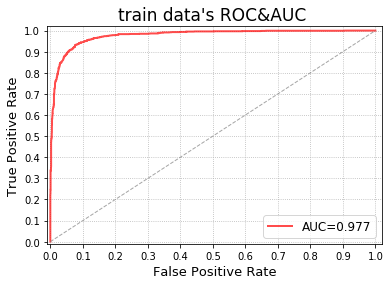

In [98]:
df = pd.read_excel('dataset.php.xlsx', header = 1)
X = df.drop('Class', axis = 1).values
y = df['Class'].values
clf = NaiveBayesBase()
clf.fit(X,y)
y_pred = clf.predict(X)
view_ROC_AUC(y, y_proba, model_name = 'Naïve Bayes')

## Decision Tree

In [67]:
df = pd.read_excel('dataset.php.xlsx', header = 1)
X = df.drop('Class', axis = 1)
y = df['Class']

clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X,y)
y_proba = clf.predict_proba(X)
y_pred = clf.predict(X)

accuracy_score(y,y_pred)

0.9090183559457302

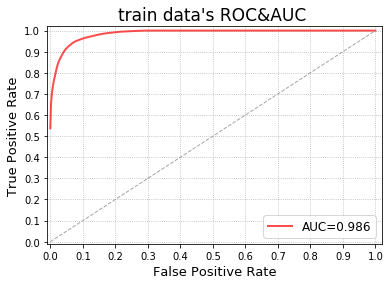

In [69]:
view_ROC_AUC(y, y_proba, model_name = 'Decesion_Tree')

## SVM

In [70]:
df = pd.read_excel('dataset.php.xlsx', header = 1)
X = df.drop('Class', axis = 1)
y = df['Class']

clf = SVC(probability=True)
clf.fit(X,y)
y_proba = clf.predict_proba(X)
y_pred = clf.predict(X)

accuracy_score(y,y_pred)

0.8810853950518756

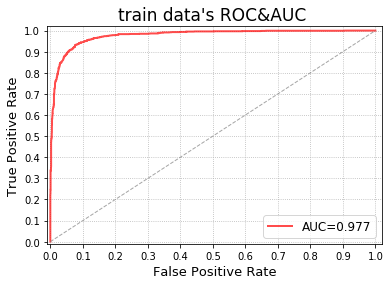

In [71]:
view_ROC_AUC(y, y_proba, model_name = 'SVM')